In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

# Construct Dataset with Best-of-N and Beam

In [ ]:
import pandas as pd

df_train_beam_numina = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_train_beam_numina.csv")
df_test_beam_numina = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/beam_numina/df_test_beam_numina.csv")

In [ ]:
df_beam_numina = pd.concat([df_train_beam_numina, df_test_beam_numina], ignore_index=True)
df_beam_numina['problem'].nunique()

9986

In [9]:
df_beam_numina = df_beam_numina.rename(columns={
    "problem": "question",
    "beam_tc": "token_count",
    "beam_latency": "time"
})
df_beam_numina["method_beam_search"] = True
df_beam_numina.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search
0,Consider the terms of an arithmetic sequence: ...,beam_search,2.0,2.0,40.0,1.000000,838,5.84,1882,True
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,beam_search,2.0,2.0,40.0,1.000000,945,3.59,8045,True
2,A farmer has a rectangular field with dimensio...,beam_search,2.0,2.0,40.0,0.566667,2999,13.43,495,True
3,Find all solutions to the equation $\displayst...,beam_search,2.0,2.0,40.0,0.000000,1989,8.75,2448,True
4,"In $\triangle ABC$, the lengths of the sides o...",beam_search,2.0,2.0,40.0,0.000000,2311,6.95,5330,True


Join Beam Variations with BoN/MV (from the first 5000 questions).

In [10]:
bon_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/softlabel_predictor_df.csv")
bon_df['beam_width'] = 0
bon_df['max_iteration'] = 0
bon_df = bon_df.drop(columns=["score", "completion_tokens", "question_length"])
bon_df.head()

,question,sb_idx,sl,N,token_count,method_maj,method_naive,method_weighted,method,beam_width,max_iteration
0,Consider the terms of an arithmetic sequence: ...,0,0.766667,2,723,False,False,True,weighted,0,0
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,1,0.533333,2,692,False,False,True,weighted,0,0
2,A farmer has a rectangular field with dimensio...,2,0.000000,2,1065,False,False,True,weighted,0,0
3,Given the functions $f(x) = \log_a(1+x)$ and $...,3,0.000000,2,1817,False,False,True,weighted,0,0
4,Find all solutions to the equation $\displayst...,4,0.933333,2,598,False,False,True,weighted,0,0


In [48]:
### Join latencies with bon_df here.
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
bon_df_w_latency = pd.merge(
    bon_df,
    latencies,
    on=["sb_idx", "N", "method"],
    how="outer"
)
bon_df_w_latency.head()

,question,sb_idx,sl,N,token_count,method_maj,method_naive,method_weighted,method,beam_width,max_iteration,time
0,Consider the terms of an arithmetic sequence: ...,0,0.466667,2,723,True,False,False,majority,0,0,2.17
1,Consider the terms of an arithmetic sequence: ...,0,0.766667,2,723,False,True,False,naive,0,0,2.70
2,Consider the terms of an arithmetic sequence: ...,0,0.766667,2,723,False,False,True,weighted,0,0,2.70
3,Consider the terms of an arithmetic sequence: ...,0,0.866667,4,1703,True,False,False,majority,0,0,2.27
4,Consider the terms of an arithmetic sequence: ...,0,0.800000,4,1703,False,True,False,naive,0,0,3.36


In [ ]:
# bon_df_w_latency['time'].isna().sum()

(75000, 12)

In [51]:
intersection = set(df_beam_numina['question']).intersection(bon_df_w_latency['question'])
df_beam_numina = df_beam_numina[df_beam_numina['question'].isin(intersection)]

concatenate beam variations (df_beam_numina) with bon (bon_df).

In [52]:
df_bon_beam = pd.concat([df_beam_numina, bon_df_w_latency], ignore_index=True)
df_bon_beam = df_bon_beam.fillna(False)

/tmp/ipykernel_2923885/2966279134.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bon_beam = df_bon_beam.fillna(False)


In [61]:
df_bon_beam.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_maj,method_naive,method_weighted
0,Consider the terms of an arithmetic sequence: ...,beam_search,2.0,2.0,40.0,1.000000,838,5.84,1882,True,False,False,False
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,beam_search,2.0,2.0,40.0,1.000000,945,3.59,8045,True,False,False,False
2,A farmer has a rectangular field with dimensio...,beam_search,2.0,2.0,40.0,0.566667,2999,13.43,495,True,False,False,False
3,Find all solutions to the equation $\displayst...,beam_search,2.0,2.0,40.0,0.000000,1989,8.75,2448,True,False,False,False
4,"In $\triangle ABC$, the lengths of the sides o...",beam_search,2.0,2.0,40.0,0.000000,2311,6.95,5330,True,False,False,False


In [ ]:
# df_bon_beam.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_df.csv", index=False)

df_bon_beam has 4998 unique questions from numina-math.
- it has columns (question, method,	N,	beam_width,	max_iteration,	sl (aka, soft label), token_count, time, sb_idx (aka, question id)).
- it is missing some latencies for best of N = 16, 32 (still collecting these lost latencies)

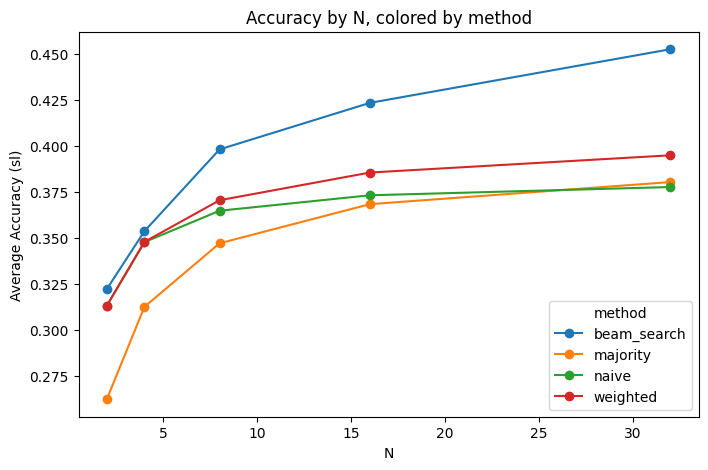

In [63]:
import matplotlib.pyplot as plt

avg_acc = df_bon_beam.groupby(["N", "method"])["sl"].mean().reset_index()
plt.figure(figsize=(8,5))
for method, group in avg_acc.groupby("method"):
    group_sorted = group.sort_values("N")
    plt.plot(group_sorted["N"], group_sorted["sl"], marker="o", label=method)
plt.xlabel("N")
plt.ylabel("Average Accuracy (sl)")
plt.title("Accuracy by N, colored by method")
plt.legend(title="method")
plt.show()

In [64]:
df_bon_beam.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_maj,method_naive,method_weighted
0,Consider the terms of an arithmetic sequence: ...,beam_search,2.0,2.0,40.0,1.000000,838,5.84,1882,True,False,False,False
1,Suppose that $g(x) = 5x - 3$. What is $g^{-1}(...,beam_search,2.0,2.0,40.0,1.000000,945,3.59,8045,True,False,False,False
2,A farmer has a rectangular field with dimensio...,beam_search,2.0,2.0,40.0,0.566667,2999,13.43,495,True,False,False,False
3,Find all solutions to the equation $\displayst...,beam_search,2.0,2.0,40.0,0.000000,1989,8.75,2448,True,False,False,False
4,"In $\triangle ABC$, the lengths of the sides o...",beam_search,2.0,2.0,40.0,0.000000,2311,6.95,5330,True,False,False,False


In [ ]:
(df_bon_beam['time'] == False).sum() # missing some times for best of N = 16, 32.

17700

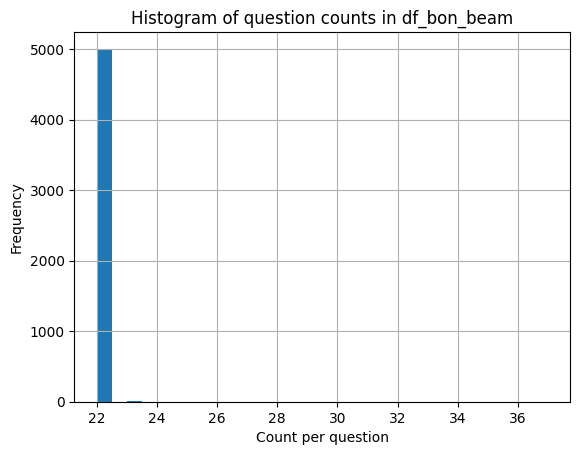

In [14]:
import matplotlib.pyplot as plt

df_bon_beam['question'].value_counts().hist(bins=30)
plt.xlabel("Count per question")
plt.ylabel("Frequency")
plt.title("Histogram of question counts in df_bon_beam")
plt.show() # we will route between 22 configurations per question.

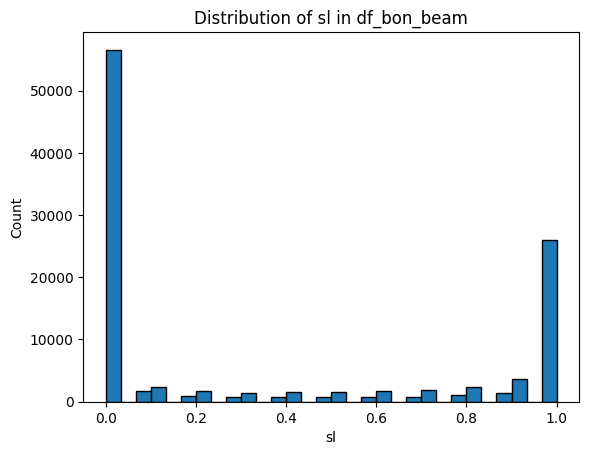

In [65]:
plt.hist(df_bon_beam['sl'], bins=30, edgecolor='k')
plt.xlabel('sl')
plt.ylabel('Count')
plt.title('Distribution of sl in df_bon_beam')
plt.show()

In [ ]:
# df_train_combined.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_combined_week12.csv", index=False)
# df_test_combined.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_combined_week12.csv", index=False)
# df_train_combined_short.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_combined_week12_short.csv", index=False)
# df_test_combined_short.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_combined_week12_short.csv", index=False)

# Add latencies

In [21]:
def adjust_question_numbering(script: str, questions_per_block: int = 25) -> str:
    """
    Adjusts the question numbering in a script where numbering resets every block of questions.

    Args:
        script (str): The input script as a string.
        questions_per_block (int): The number of questions per block before numbering resets.

    Returns:
        str: The adjusted script with continuous question numbering.
    """
    import re

    # Split the script into lines
    lines = script.strip().split("\n")

    # Initialize variables
    adjusted_lines = []
    current_offset = 0

    # Process each line
    for line in lines:
        # Match lines with "Generation for question" or "Scoring for question"
        match = re.match(r"(Generation|Scoring) for question (\d+) (.+)", line)
        if match:
            action = match.group(1)  # "Generation" or "Scoring"
            question_number = int(match.group(2))  # Extract question number
            rest_of_line = match.group(3)  # The rest of the line

            # Adjust the question number
            adjusted_question_number = question_number + current_offset

            # Reconstruct the line with the adjusted question number
            adjusted_line = f"{action} for question {adjusted_question_number} {rest_of_line}"
            adjusted_lines.append(adjusted_line)
        elif "Total best-of-N process" in line:
            # Increment the offset after each block of questions
            current_offset += questions_per_block
            adjusted_lines.append(line)
        else:
            # Keep other lines unchanged
            adjusted_lines.append(line)

    # Join the adjusted lines back into a single script
    return "\n".join(adjusted_lines)

In [32]:
### Perform for all latency .out files.
# Read the file content
with open("/dccstor/gma2/jhjenny9/search-and-learn/bon-outs/best-of-16.out", "r") as file:
    script = file.read()

# Adjust the question numbering
adjusted_script = adjust_question_numbering(script, 25)

# Write the modified content back to the file
with open("/dccstor/gma2/jhjenny9/search-and-learn/bon-outs/best-of-16-adjusted.out", "w") as file:
    file.write(adjusted_script)

In [16]:
import re
import pandas as pd
from collections import defaultdict

def extract_latency(out_filepath, N):
    """
    Extracts latency information from the .out file and returns a DataFrame.
    
    Args:
        out_filepath (str): Path to the .out file.
        N (int): Number of generations to sum latency for.
        
    Returns:
        pd.DataFrame: DataFrame containing sb_idx, generation times, and combined scoring+generation times.
    """
    gen_times = defaultdict(list)
    score_times = {}
 
    # Read the .out file and extract relevant information
    with open(out_filepath, "r") as file:
        for line in file:
            # Match generation time for each question
            gen_match = re.search(r"Generation for question (\d+) completed in ([\d.]+) seconds", line)
            if gen_match:
                q_num = int(gen_match.group(1))
                gen_time = float(gen_match.group(2))
                gen_times[q_num].append(gen_time)

            # Match scoring time for each question
            score_match = re.search(r"Scoring for question (\d+) completed in ([\d.]+) seconds", line)
            if score_match:
                q_num = int(score_match.group(1))
                score_time = float(score_match.group(2))
                score_times[q_num] = score_time

    # Build final data dictionary
    data = {
        "sb_idx": [],
        "maj": [],
        "weighted": [],
        "naive": [],
        "N": []
    }

    for q_num in sorted(gen_times.keys()):
        gen_total = sum(gen_times[q_num])
        score = score_times.get(q_num, 0.0)
        data["sb_idx"].append(q_num - 1)  # sb_idx starts from 0
        data["maj"].append(gen_total)
        combined = gen_total + score
        data["weighted"].append(combined)
        data["naive"].append(combined)
        data["N"].append(N)

    return pd.DataFrame(data)


In [33]:
# Filepath to the .out file
bo2_latency = "/dccstor/gma2/jhjenny9/search-and-learn/bon-outs/best-of-2-adjusted.out"
bo4_latency = "/dccstor/gma2/jhjenny9/search-and-learn/bon-outs/best-of-4-adjusted.out"
bo8_latency = "/dccstor/gma2/jhjenny9/search-and-learn/bon-outs/best-of-8-adjusted.out"
bo16_latency = "/dccstor/gma2/jhjenny9/search-and-learn/bon-outs/best-of-16-adjusted.out"

N2_latency = extract_latency(bo2_latency, 2)
N4_latency = extract_latency(bo4_latency, 4)
N8_latency = extract_latency(bo8_latency, 8)
N16_latency = extract_latency(bo16_latency, 16)


In [38]:
N8_latency.shape

(5000, 5)

In [40]:
# Concat all latencies into a single DataFrame
All_latencies_raw = pd.concat([N2_latency, N4_latency, N8_latency, N16_latency], ignore_index=True)

In [42]:
All_latencies_raw.tail()

,sb_idx,maj,weighted,naive,N
19095,4095,8.91,10.95,10.95,16
19096,4096,7.18,8.83,8.83,16
19097,4097,1.55,1.97,1.97,16
19098,4098,4.87,6.10,6.10,16
19099,4099,6.61,8.20,8.20,16


In [43]:
# Pivot to long format
latencies = pd.melt(
    All_latencies_raw,
    id_vars=["sb_idx", "N"],
    value_vars=["maj", "naive", "weighted"],
    var_name="method",
    value_name="time"
)

# Clean up method names
latencies["method"] = latencies["method"].str.replace("_time", "")

In [46]:
latencies["method"] = latencies["method"].replace("maj", "majority")
latencies.head()

,sb_idx,N,method,time
0,0,2,majority,2.17
1,1,2,majority,2.22
2,2,2,majority,4.30
3,3,2,majority,4.64
4,4,2,majority,1.02


In [47]:
# Now group by N and method to get average time
avg_time = latencies.groupby(["N", "method"])["time"].mean().reset_index()
avg_time.head(15)

,N,method,time
0,2,majority,3.188012
1,2,naive,3.309206
2,2,weighted,3.309206
3,4,majority,3.810374
4,4,naive,4.064378
5,4,weighted,4.064378
6,8,majority,4.387732
7,8,naive,4.939396
8,8,weighted,4.939396
9,16,majority,5.050239


Join latencies with bon_df before concatenating with numina beam df (done in a cell above).

# Routing

In [ ]:
# do a train test split, and keep track of indices.

from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df_bon_beam, test_size=0.2, random_state=42)
# train_indices = train_df.index
# test_indices = test_df.index

# create train/test split based on 'sb_idx' (query identifier)

unique_sb_idx = df_bon_beam['sb_idx'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.20, # .15
    random_state=6
)

# Divide queries (represented by sb_idx) into train and test
df_train = df_bon_beam[df_bon_beam['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = df_bon_beam[df_bon_beam['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [8]:
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_train_df.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_test_df.csv", index=False)

df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_train_df.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_test_df.csv")

df_train.head()
df_test.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_maj,method_naive,method_weighted
0,A farmer has a rectangular field with dimensio...,beam_search,2.0,2.0,40.0,0.566667,2999,13.43,495,True,False,False,False
1,Compute $\cos 225^\circ$.,beam_search,2.0,2.0,40.0,0.000000,229,0.75,1751,True,False,False,False
2,A set consists of five different odd positive ...,beam_search,2.0,2.0,40.0,1.000000,1232,4.62,903,True,False,False,False
3,"In triangle $ABC$, $CA = CB$, and $D$ is the m...",beam_search,2.0,2.0,40.0,0.000000,1441,4.93,5998,True,False,False,False
4,"Suppose that $A, B, C, D$ are four points in t...",beam_search,2.0,2.0,40.0,0.000000,2659,11.23,8043,True,False,False,False


In [9]:
df_test.shape

(22076, 13)

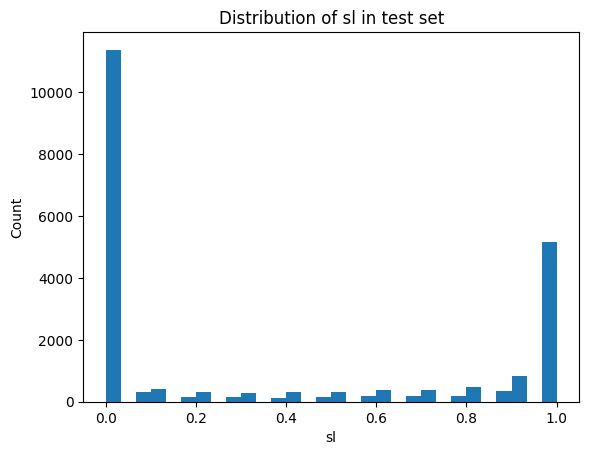

In [8]:
plt.hist(df_test["sl"], bins=30)
plt.xlabel("sl")
plt.ylabel("Count")
plt.title("Distribution of sl in test set")
plt.show()


/tmp/ipykernel_2923885/978253153.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/tmp/ipykernel_2923885/978253153.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")


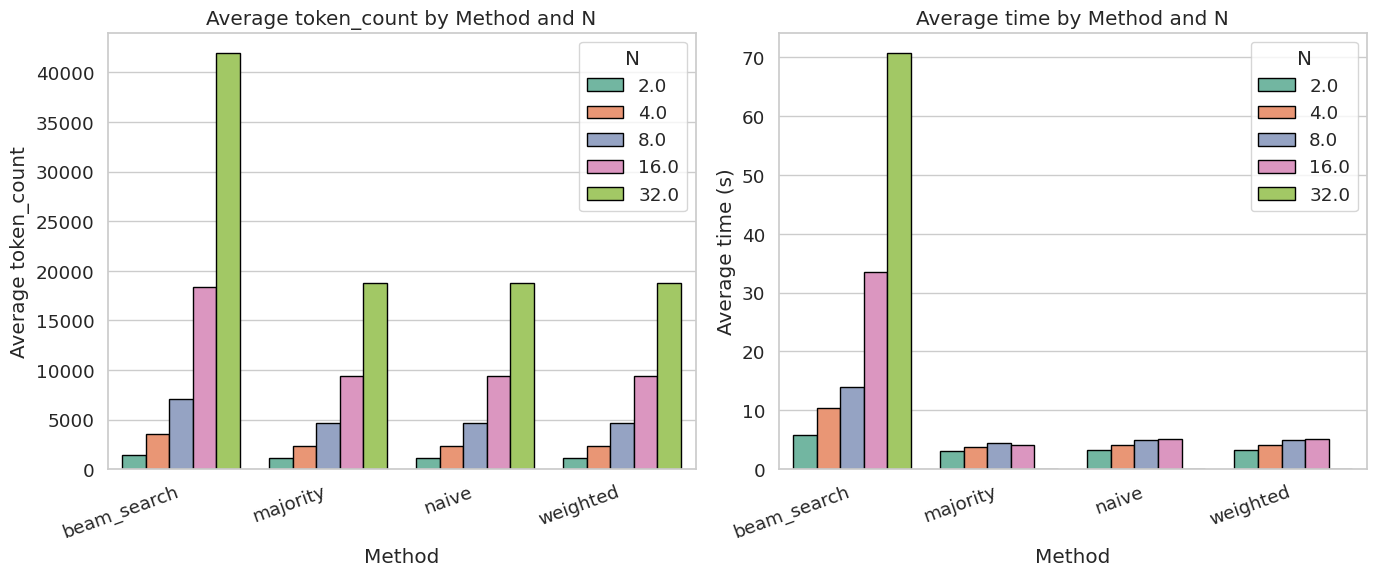

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

palette = sns.color_palette("Set2", n_colors=len(df_bon_beam["N"].unique()))

# token_count plot
df_token = df_bon_beam.groupby(["method", "N"])["token_count"].mean().reset_index()
sns.barplot(
    data=df_token,
    x="method",
    y="token_count",
    hue="N",
    ax=axs[0],
    palette=palette,
    edgecolor="black"
)
axs[0].set_ylabel("Average token_count")
axs[0].set_xlabel("Method")
axs[0].set_title("Average token_count by Method and N")
axs[0].legend(title="N", loc="upper right", frameon=True)

# time plot
df_time = df_bon_beam.groupby(["method", "N"])["time"].mean().reset_index()
sns.barplot(
    data=df_time,
    x="method",
    y="time",
    hue="N",
    ax=axs[1],
    palette=palette,
    edgecolor="black"
)
axs[1].set_ylabel("Average time (s)")
axs[1].set_xlabel("Method")
axs[1].set_title("Average time by Method and N")
axs[1].legend(title="N", loc="upper right", frameon=True)

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")

plt.tight_layout()
plt.show()



In [6]:
ys = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model/true_labels.npy")
calibrated_probs = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model/calibrated_probs.npy")

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape

(21999,) 5.181349479244091e-06 0.9999912977218628
(21999,) 0.0 1.0


((21999,), (21999,))

In [ ]:
ys[:10]

array([0.        , 0.        , 0.26666668, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [12]:
df_test['sl'][:10]

0    0.566667
1    0.000000
2    1.000000
3    0.000000
4    0.000000
5    1.000000
6    1.000000
7    0.000000
8    0.000000
9    0.000000
Name: sl, dtype: float64

In [ ]:
df_test['calibrated_probs'] = calibrated_probs

In [4]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test["bin"] = pd.cut(calibrated_probs, bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test.groupby("bin").agg(
    avg_pred_prob=("calibrated_probs", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'calibrated_probs' is not defined

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.


In [ ]:
# create features for this test set.
# bsub -gpu "num=1/task:mode=exclusive_process:gmodel=NVIDIAA100_SXM4_80GB" -M 200G -J heart-feature -oo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.out -eo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.err python scripts/features/extract_features_simple.py --input_csv /dccstor/gma2/jhjenny9/search-and-learn/data/heart/df_test_heart.csv

# perform inference on this test set.
# python scripts/training/train_calib.py \
#   --X_train /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-train/X.npy \
#   --y_train /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-train/y.npy \
#   --X_test /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-test/X.npy \
#   --y_test /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-test/y.npy \
#   --output_dir /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model

# python scripts/training/train_calib.py \
#   --X_train /dccstor/gma2/jhjenny9/search-and-learn/data/heart/X_train_80.npy \
#   --y_train /dccstor/gma2/jhjenny9/search-and-learn/data/heart/y_train_80.npy \
#   --X_test /dccstor/gma2/jhjenny9/search-and-learn/data/heart/X_test_20.npy \
#   --y_test /dccstor/gma2/jhjenny9/search-and-learn/data/heart/y_test_20.npy \
#   --output_dir /dccstor/gma2/jhjenny9/search-and-learn/data/big_heart

# load in the calibrated probabilities.
calibrated_probs = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model/calibrated_probs.npy")
ys = np.load('/dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model/true_labels.npy')

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape


FileNotFoundError: [Errno 2] No such file or directory: '/dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model/calibrated_probs.npy'

In [ ]:
df_test['calibrated_probs'] = calibrated_probs
df_test.head()

/tmp/ipykernel_904152/873634620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_heart_test['calibrated_probs'] = calibrated_probs


In [83]:
df_test.groupby("sb_idx").count()

,question,method,N,beam_width,max_iteration,sl,token_count,time,method_beam_search,method_maj,method_naive,method_weighted
sb_idx,,,,,,,,,,,,
10,15,15,15,15,15,15,15,15,15,15,15,15
11,22,22,22,22,22,22,22,22,22,22,22,22
14,15,15,15,15,15,15,15,15,15,15,15,15
15,22,22,22,22,22,22,22,22,22,22,22,22
22,15,15,15,15,15,15,15,15,15,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...
9948,7,7,7,7,7,7,7,7,7,7,7,7
9969,7,7,7,7,7,7,7,7,7,7,7,7
9973,7,7,7,7,7,7,7,7,7,7,7,7


In [85]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_test.groupby(["N", "beam_width", "max_iteration", "method"])[
    ["token_count", "sl", "calibrated_probs"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

KeyError: "Columns not found: 'calibrated_probs'"

In [209]:
config_summary_df.head(10)

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs
0,2.0,0.0,0.0,majority,953.944444,2.362778,0.445556,0.590427
1,2.0,0.0,0.0,naive,1088.368421,2.861579,0.356842,0.469075
2,2.0,0.0,0.0,weighted,1201.423077,3.288462,0.325385,0.450264
3,2.0,2.0,40.0,beam_search,1353.500000,5.191667,0.166667,0.233931
4,2.0,4.0,40.0,beam_search,1429.800000,6.514667,0.334667,0.323283
5,4.0,0.0,0.0,majority,2161.318182,3.563182,0.467273,0.532980
6,4.0,0.0,0.0,naive,1982.608696,4.052609,0.546957,0.570630
7,4.0,0.0,0.0,weighted,2148.125000,3.875417,0.540833,0.542283
8,4.0,2.0,40.0,beam_search,4082.250000,12.977500,0.125000,0.259821
9,4.0,4.0,40.0,beam_search,3628.111111,9.666667,0.246667,0.264787


In [ ]:
def compute_max_utility_pred(df, lambda_, method="oracle", cost="token_count"):
    def get_max_utility(group):
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[cost]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[cost]
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "beam_width": group.loc[idx_max, "beam_width"],
            "max_iteration": group.loc[idx_max, "max_iteration"]
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [ ]:
def get_router_df(input_df, lambda_list, method="oracle", cost="token_count"):
    results = []

    for lambda_value in lambda_list:
        adaptive_router = compute_max_utility_pred(input_df, lambda_value, method, cost)
        average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
        average_cost = adaptive_router["max_cost"].mean()
        average_time = adaptive_router["max_time"].mean()
        average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
        
        results.append({
            "lambda": lambda_value,
            "sl": average_accuracy,
            "token_count": average_cost,
            "predicted_prob": average_predicted_prob,
            "time": average_time,
        })

    # Convert to DataFrame
    output_df = pd.DataFrame(results)
    output_df["method"] = method

    return output_df


In [212]:
adaptive_tc = get_router_df(df_test_filtered, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", cost="token_count")
oracle_tc = get_router_df(df_test_filtered, lambda_list=np.logspace(-7, -1, num=50), method="oracle", cost="token_count")

adaptive_lat = get_router_df(df_test_filtered, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", cost="time")
oracle_lat = get_router_df(df_test_filtered, lambda_list=np.logspace(-5, -1, num=50), method="oracle", cost="time")

/tmp/ipykernel_904152/1882384397.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_904152/1882384397.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_904152/1882384397.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping colum

In [213]:
adaptive_tc.head()

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-07,0.572947,15282.434783,0.573514,12.658551,adaptive_router
1,1.325711e-07,0.572947,14587.652174,0.573432,11.386957,adaptive_router
2,1.757511e-07,0.572947,13367.623188,0.573219,10.526957,adaptive_router
3,2.329952e-07,0.572947,12767.985507,0.573088,9.968696,adaptive_router
4,3.088844e-07,0.572947,12478.594203,0.573000,9.562319,adaptive_router


In [214]:
oracle_tc.head()

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-07,0.690725,9255.898551,0.514147,10.926957,oracle
1,1.325711e-07,0.690725,9255.898551,0.514147,10.926957,oracle
2,1.757511e-07,0.690725,9255.898551,0.514147,10.926957,oracle
3,2.329952e-07,0.690725,9255.898551,0.514147,10.926957,oracle
4,3.088844e-07,0.690725,9255.898551,0.514147,10.926957,oracle


In [215]:
oracle_lat.head()

,lambda,sl,token_count,predicted_prob,time,method
0,0.000010,0.690725,9262.84058,0.514272,10.916812,oracle
1,0.000012,0.690725,9262.84058,0.514272,10.916812,oracle
2,0.000015,0.690725,9262.84058,0.514272,10.916812,oracle
3,0.000018,0.690725,9262.84058,0.514272,10.916812,oracle
4,0.000021,0.690725,9262.84058,0.514272,10.916812,oracle


In [216]:
adaptive_tc['N'] = -1
adaptive_tc['beam_width'] = -1
adaptive_tc['max_iteration'] = -1

adaptive_lat['N'] = -1
adaptive_lat['beam_width'] = -1
adaptive_lat['max_iteration'] = -1

oracle_tc['N'] = -1
oracle_tc['beam_width'] = -1
oracle_tc['max_iteration'] = -1

oracle_lat['N'] = -1
oracle_lat['beam_width'] = -1
oracle_lat['max_iteration'] = -1

In [217]:
config_summary_df.rename(columns={"calibrated_probs": "predicted_prob"}, inplace=True)

In [218]:
config_summary_df.head(25)

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
0,2.0,0.0,0.0,majority,953.944444,2.362778,0.445556,0.590427
1,2.0,0.0,0.0,naive,1088.368421,2.861579,0.356842,0.469075
2,2.0,0.0,0.0,weighted,1201.423077,3.288462,0.325385,0.450264
3,2.0,2.0,40.0,beam_search,1353.500000,5.191667,0.166667,0.233931
4,2.0,4.0,40.0,beam_search,1429.800000,6.514667,0.334667,0.323283
5,4.0,0.0,0.0,majority,2161.318182,3.563182,0.467273,0.532980
6,4.0,0.0,0.0,naive,1982.608696,4.052609,0.546957,0.570630
7,4.0,0.0,0.0,weighted,2148.125000,3.875417,0.540833,0.542283
8,4.0,2.0,40.0,beam_search,4082.250000,12.977500,0.125000,0.259821
9,4.0,4.0,40.0,beam_search,3628.111111,9.666667,0.246667,0.264787


In [219]:
config_summary_df[config_summary_df["method"] == "naive"]

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
1,2.0,0.0,0.0,naive,1088.368421,2.861579,0.356842,0.469075
6,4.0,0.0,0.0,naive,1982.608696,4.052609,0.546957,0.570630
11,8.0,0.0,0.0,naive,4357.526316,4.416842,0.456842,0.505679
16,16.0,0.0,0.0,naive,7505.800000,5.318000,0.580000,0.571428
22,32.0,0.0,0.0,naive,14870.550000,7.942500,0.668000,0.634722


In [220]:
oracle_tc.head()

,lambda,sl,token_count,predicted_prob,time,method,N,beam_width,max_iteration
0,1.000000e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
1,1.325711e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
2,1.757511e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
3,2.329952e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1
4,3.088844e-07,0.690725,9255.898551,0.514147,10.926957,oracle,-1,-1,-1


In [221]:
# outer join on the shared columns
df_1_tc = pd.merge(
    adaptive_tc,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
df_2_tc = pd.merge(
    df_1_tc,
    oracle_tc,
    on=["lambda", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
# Replace NaN values with -1 for plotting purposes
query_optimal_tc = df_2_tc.fillna(-1)

In [223]:
# outer join on the shared columns
df_1_late = pd.merge(
    adaptive_lat,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
df_2_late = pd.merge(
    df_1_late,
    oracle_lat,
    on=["lambda", "method", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration"],
    how="outer"
)

# Replace NaN values with -1 for plotting purposes
query_optimal_late = df_2_late.fillna(-1)

In [224]:
query_optimal_tc['method'].unique() 

array(['adaptive_router', 'oracle', 'beam_search', 'weighted', 'naive',
       'majority'], dtype=object)

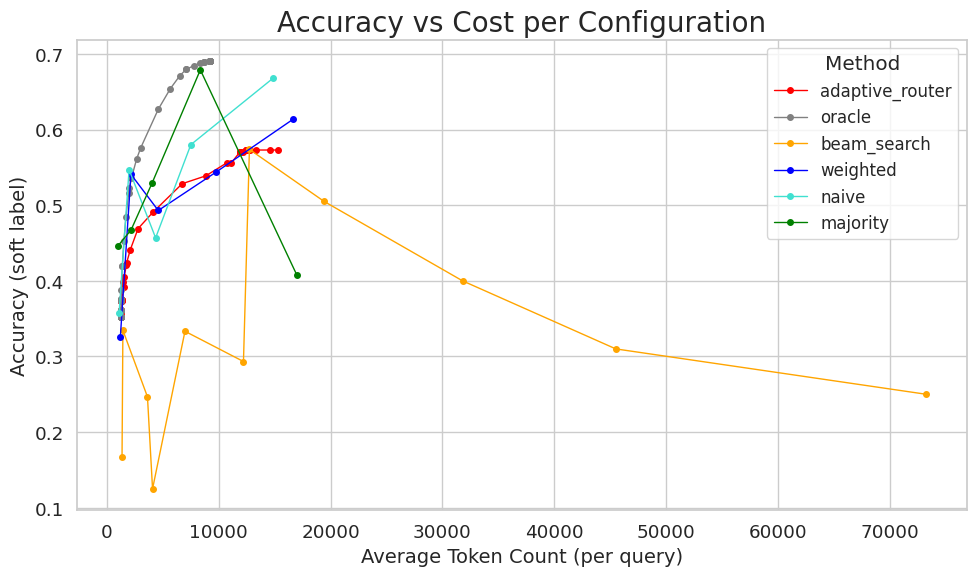

In [225]:
# Assign unique colors for each method
method_colors = {
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Token Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [149]:
config_summary_df[config_summary_df["method"] == "weighted"]

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
2,2.0,0.0,0.0,weighted,1051.289926,3.063661,0.475577,0.448851
7,4.0,0.0,0.0,weighted,2131.972222,3.677389,0.534778,0.454054
12,8.0,0.0,0.0,weighted,4394.471338,4.806943,0.529873,0.449289
17,16.0,0.0,0.0,weighted,9351.636015,6.778544,0.462222,0.462838
23,32.0,0.0,0.0,weighted,19871.315789,10.034928,0.414354,0.529731
